In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import math as m
from scipy.optimize import curve_fit
import geopandas as geo
import os

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
plt.style.use('classic')

def CreateFolder(directory):
    try :
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory.' + directory)
add = './N Se_20_4_oco_co_mi'#taghir baray kar
add2='./oco2_co2_middle_east_1_g.txt'
CreateFolder(str(add))

data_v =  np.loadtxt(str(add2),dtype=[('lat','f8'),('lon','f8'),
                                                         ('time','f8'),('co2','f8'),('var','f8')])

a      = np.zeros((data_v.shape[0],4))
a[:,0] = data_v['lat']
a[:,1] = data_v['lon']
a[:,2] = (data_v['time']-1)//3 + 1
a[:,3] = data_v['co2']


def g_d(lat1,lon1,lat2,lon2):
    R = 6371.009
    lat1 = lat1*np.pi/180
    lat2 = lat2*np.pi/180
    lon1 = lon1*np.pi/180
    lon2 = lon2*np.pi/180
    return R*np.arccos(np.sin(lat1)*np.sin(lat2)+np.cos(lat1)*np.cos(lat2)*np.cos(lon1-lon2))
def AA_spatialtemporalsemig(data,S_LagNum,S_Lagleng,T_LagNum,T_Lagleng):
    d  = 500
    N  = len(data[:,0])
    NN = m.ceil(len(data[:,0])/d)
    semig      = np.zeros((T_LagNum,S_LagNum))
    semigCount = np.zeros((T_LagNum,S_LagNum))
    semigSpaDisAve = np.zeros((T_LagNum,S_LagNum))
    semigTemDisAve = np.zeros((T_LagNum,S_LagNum))
    for i in range(NN):
        vector    = data[d*i:,:,np.newaxis]
        ind       = np.array((np.ones((vector.shape[0],len(data[d*i:d*(i+1),0])))*
                              np.arange(d*i,d*i+len(data[d*i:d*(i+1),0]))),dtype=np.int).T
        dind      = np.arange(d*i,N,dtype=np.int)
        distInd   = dind - ind
        distSpat  = g_d(data[d*i:d*(i+1),0],data[d*i:d*(i+1),1],vector[:,0],vector[:,1]).T
        distTemp  = (vector[:,3] - data[d*i:d*(i+1),3]).T
        distCo2   = (data[d*i:d*(i+1),2] - vector[:,2]) ** 2
        distCo2   = np.triu(distCo2.T)
        indxSpat  = np.array(distSpat/S_Lagleng)
        indxTemp  = np.array(distTemp/T_Lagleng)
        for js in range(S_LagNum):
            for jt in range (T_LagNum):
                semig[jt,js] = semig[jt,js] + np.sum(distCo2[(distInd>0)&(js<=indxSpat)&(indxSpat<(js+1))&
                                                             (jt<=indxTemp)&(indxTemp<(jt+1))])
                semigCount[jt,js] = semigCount[jt,js] + len(distCo2[(distInd>0)&(js<=indxSpat)&
                                                                    (indxSpat<(js+1))&
                                                                    (jt<=indxTemp)&
                                                                    (indxTemp<(jt+1))])

    semig=semig/(semigCount*2)
    #semigSpaDisAve=semigSpaDisAve/semigCount
    #semigTemDisAve=semigTemDisAve/semigCount
    
    return semig,semigCount#,semigSpaDisAve,semigTemDisAve

def AA_CressieIterativeWLS_STsemig(ST_semig,ST_semigCount,start):
    nt = ST_semig.shape[0]
    ns = ST_semig.shape[1]
    
    semig      = np.zeros((nt*ns,4))
    semig[:,0] = ST_semigCount.reshape(nt*ns,order='F')
    semig[:,3] = ST_semig.reshape(nt*ns,order='F')
    semig[0,0] = semig[0,0]*10. # 10 or 5 or 1 
    
    for i in range (ns):
        semig[((i+1)*nt-nt):(i+1)*nt,1] = (i+1)*100-50
        semig[((i+1)*nt-nt):(i+1)*nt,2] = np.arange(4.5,10*nt,10) 
    
    hs = semig[:,1];
    ht = semig[:,2];
    
    def f_hs(ks,hs): 
        return ks[0]*(1.-np.exp((-1.)*(hs/ks[1])))
    def f_ht(kt,ht):
        return kt[0]*(1.-np.exp((-1.)*(ht/kt[1])))
    def modelFun(x,k): 
        return f_hs(k[:2],x[0]) + f_ht(k[2:4],x[1]) - k[4]*f_hs(k[0:2],x[0])*f_ht(k[2:4],x[1])+k[5]
    
    x  = np.array([hs,ht])
    ww = np.sqrt(semig[:,0])/modelFun(x,start)
    yw = ww*semig[:,3]
    
    def modelFunw(x,k1,k2,k3,k4,k5,k6):
        k = np.array([k1,k2,k3,k4,k5,k6])
        return ww * modelFun(x,k)
    
    #[bFitw] = nlinfit(x,yw,modelFunw,start)
    bFitw,_ = curve_fit(modelFunw,x,yw,start)
    
    i  =1
    ee =1e-8
    while np.sum((bFitw-start)**2)>ee :
        start = bFitw
        ww    = np.sqrt(semig[:,0])/modelFun(x,start)
        yw    = ww * semig[:,3]
        #def modelFunw(k,x):
        #    return ww * modelFun(k,x)
        bFitw,_ = curve_fit(modelFunw,x,yw,start)
        i     = i + 1
    
    W_theta     = np.sum(semig[:,0] * ((semig[:,3] / modelFun(x,bFitw)) - 1.) ** 2)
    OutputSemig = np.array([hs,ht,modelFun(x,bFitw)])
    InputSemig  = semig[:,[1,2,3]]
    return bFitw,i,InputSemig,OutputSemig

def myfun(hs,ht,bFitw):
    ######Product-Sum + Global Nugget#######################
    def f_hs(ks,hs): 
        return ks[0]*(1.-np.exp((-1.)*(hs/ks[1])))
    def f_ht(kt,ht):
        return kt[0]*(1.-np.exp((-1.)*(ht/kt[1])))
    def modelFun(x,k): 
        return f_hs(k[:2],x[0]) + f_ht(k[2:4],x[1]) - k[4]*f_hs(k[0:2],x[0])*f_ht(k[2:4],x[1])+k[5]
    ########################################################
    
    # f_hs=@(ks,hs) ks(1)*(1-exp((-1)*hs./ks(2)));
    # f_ht=@(kt,ht) kt(1)*(1-exp((-1)*(ht.^2)/kt(2)));
    # modelFun=@(k,x) f_hs(k(1:2),x(:,1))+f_ht(k(3:4),x(:,2))-k(5)*f_hs(k(1:2),x(:,1)).*f_ht(k(3:4),x(:,2))+k(6);
    x  = np.array([hs,ht])
    return modelFun(x,bFitw)

def SpatialTemporalKrigPrediction_ACOS(ObservedData,WaitForKrig,bFitw):
    #ObservedData [lat,lon,co2,day],
    #fun myfun(hs,ht),
    #WaitForKrig [lat,lon,day]
    #lastValue PredVar, prediction variance

    N = ObservedData.shape[0]
    v = np.ones((N+1,N+1))
    y = np.zeros((N+1,1))
    vstar = np.ones((N+1,1))
    
    for i in range (N):
        v[i,:N] = myfun(g_d(ObservedData[i,0],ObservedData[i,1],ObservedData[:,0],ObservedData[:,1]),
                        np.abs(ObservedData[i,3] - ObservedData[:,3]),bFitw)
        

    v = np.real(v)
    np.fill_diagonal(v,0)
    y[:N,0] = ObservedData[:,2]

    hs = g_d(WaitForKrig[0],WaitForKrig[1],ObservedData[:,0],ObservedData[:,1])
    ht = np.abs(WaitForKrig[2] - ObservedData[:,3])
    vstar[:N,0] = myfun(hs,ht,bFitw)
    
    tem     = np.matmul(np.linalg.inv(v), y)#tem=v\y' #the same as inv(v)*y; result is column vector
    
    lastVal = np.matmul(vstar.T,tem)
    PredVar = np.matmul(vstar.T,np.matmul(np.linalg.inv(v),vstar))
                        
    return lastVal,PredVar  

def SpatialTemporalKriging_ACOS(ObservedData,PredPos,bFitw):
    #[ObservedData]= [lat,lon,co2,day3], is the global ACOS data except the PredPos
    #[PredPos]= [lat,lon,day], 
    #TempTrend [482,1] 482 time units
    #Fitw [6 coefficients]
    ############tic
    NN = PredPos.shape[0]
    KrigSearchNumRadius = np.zeros((NN,3))
    KrigResult = np.zeros((NN,1))
    PredictVar = np.zeros((NN,1))

    for i in range (NN):     
        #krigData=PredPos(i,:)
        #find the points
        distSpatial  = g_d(PredPos[i,0],PredPos[i,1],ObservedData[:,0],ObservedData[:,1])
        distTemporal = np.abs(PredPos[i,2] - ObservedData[:,3])
    
        a    = 300
        b    = 1 #different from IEEE TGRS, because more data available, original [300,20]
        indx = (distSpatial<=a)&(distTemporal<=b)

        while np.sum(len(indx[np.where(indx==True)]))<20 :
            a    = a + 100 #expand until at least 20 data points are available
            b    = b + 1
            indx = (distSpatial<=a)&(distTemporal<=b)

        KrigSearchNumRadius[i,:] = np.array([np.sum(len(indx[np.where(indx==True)])),a,b])
        ObservedData2            = ObservedData[indx,:]
        
        lastVal,PredVar = SpatialTemporalKrigPrediction_ACOS(ObservedData2,PredPos[i,:],bFitw) 
        KrigResult[i]   = lastVal
        PredictVar[i]   = PredVar
          
    return KrigResult,KrigSearchNumRadius,PredictVar

def STK_Mapping_ACOS(ACOSDataRes,bFitw,TempTrend,SpatialTrendPara,InterpGrids):
    # Mapping Northern China with uniform trend
    # Feb 27, 2016
    # ACOSData3 is the Northern China residual data [lat,lon,XCO2res,Day3]
    # TempTrend [122 time-units], SpatialTrendPara [b0,b1,b2] which are fitted surface parameters
    # InterpGrids [lat,lon], grids to be interpolated
    
    NN = InterpGrids.shape[0]
    
    MapKrigResult = np.zeros((NN,TT))
    MapKrigNum    = np.zeros((NN,TT))
    MapKrigSpaRad = np.zeros((NN,TT))
    MapKrigTemRad = np.zeros((NN,TT))
    MapPredictVar = np.zeros((NN,TT))
    PredPos       = np.zeros((NN,3))

    # Spatial Trend
    SpatialTrend2 = (np.ones((NN)) * SpatialTrendPara[0] 
                     + InterpGrids[:,0] * SpatialTrendPara[1]
                     + InterpGrids[:,1] * SpatialTrendPara[2])
    
    for j in range (TT) :
        PredPos[:,0] = InterpGrids[:,0]
        PredPos[:,1] = InterpGrids[:,1]
        PredPos[:,2] = j+1
        KR,KNumKSRadKTRad,PredVar = SpatialTemporalKriging_ACOS(ACOSDataRes,PredPos,bFitw)
        KR         = KR[:,0]
        PredVar    = PredVar[:,0]
        TempTrend2 = TempTrend[j]
        KR = KR + SpatialTrend2
        KR = KR + TempTrend2
        
        MapKrigResult[:,j] = KR
        MapKrigNum[:,j]    = KNumKSRadKTRad[:,0]
        MapKrigSpaRad[:,j] = KNumKSRadKTRad[:,1]
        MapKrigTemRad[:,j] = KNumKSRadKTRad[:,2]
        MapPredictVar[:,j] = PredVar
    return MapKrigResult,MapKrigNum,MapKrigSpaRad,MapKrigTemRad,MapPredictVar

def func1(x, a,b,c):
    return a + b*x[:,0] + c*x[:,1]

def func(x, a0,a1,a2,a3,a4,a5):
    omega= (2*np.pi)/TT
    sin = a2 * np.sin(omega * x) + a4 * np.sin(2*omega*x)
    cos = a3 * np.cos(omega * x) + a5 * np.cos(2*omega*x)
    return a0 + a1 * x  + sin + cos

step1
step2
step3
step4


C:\Users\Mohsen\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


step5


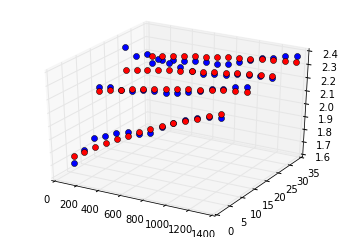

In [2]:
#step1
#removing spatial trend
n_m = 20
TT  = 4

BB, pcov = curve_fit(func1, a, a[:,3])
s_trend  = func1(a,*BB)
spa_res  = a[:,3] - s_trend
print('step1')
#step 2
#removing Ttiming Trend
spa_res_tmean = np.zeros((1,n_m))
for i in range (1,n_m+1):
    spa_res_tmean[0,i-1] = np.mean(spa_res[a[:,2]==i])

params2, pcov2 = curve_fit(func, np.arange(1,n_m+1,dtype=np.float), spa_res_tmean[0])

CHNXCO2DataSemiMonSpaResTemTrend = func(np.arange(1,n_m+1,dtype=np.float),*params2)

spa_res_t_res = np.zeros(spa_res.shape)
time_t        = func(np.arange(1,n_m+1,dtype=np.float),*params2)
for i in range(1,n_m+1):
    spa_res_t_res[a[:,2]==i] = spa_res[a[:,2]==i] - time_t[i-1]
    
data      = np.zeros((a.shape))
data[:,0] = a[:,0]
data[:,1] = a[:,1]
data[:,3] = a[:,2]
data[:,2] = spa_res_t_res
DataSemiMonSpaResTemRes = data
print('step2')
##step 3
try :
    CHNsemig      = np.loadtxt('./'+str(add)+'/CHNsemig.txt')
    CHNsemigCount = np.loadtxt('./'+str(add)+'/CHNsemigCount.txt')
except :
    CHNsemig,CHNsemigCount = AA_spatialtemporalsemig(data,20,100,4,1)
    np.savetxt('./'+str(add)+'/CHNsemig.txt',CHNsemig)
    np.savetxt('./'+str(add)+'/CHNsemigCount.txt',CHNsemigCount)
print('step3')   
##Step 4
#Spatiotemporal variogram modeling
#Using Product-Sum model by De Iaco et al. (2001)

T = 8
S = 14
sta =  np.array([2.,1000.,1.5,5.,0.1,1.])
t_bFitw,ii,t_InputSemig,t_OutputSemig = AA_CressieIterativeWLS_STsemig(CHNsemig[:T,:S],CHNsemigCount[:T,:S],sta)
fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')
ax.plot(t_InputSemig[:,0],t_InputSemig[:,1],t_InputSemig[:,2],'o')
ax.plot(t_OutputSemig[0],t_OutputSemig[1],t_OutputSemig[2],'or')
print('step4')
#step 5
CHNXCO2Data_bFitw = t_bFitw
SpatialTrendPara  = BB
TempTrend         = CHNXCO2DataSemiMonSpaResTemTrend

tLat        = np.arange(11,44,0.5)
tLon        = np.arange(23,65,0.5)
tPlg,tPlt   = np.meshgrid(tLon,tLat)
InterpGrids = np.array([tPlt,tPlg]).reshape(2,tLat.size*tLon.size,order='F').T #cordinates of map
try:
    MapKrigResult = np.loadtxt('./'+str(add)+'/MapKrigResult')
    MapKrigNum    = np.loadtxt('./'+str(add)+'/MapKrigNum')
    MapKrigSpaRad = np.loadtxt('./'+str(add)+'/MapKrigSpaRad')
    MapKrigTemRad = np.loadtxt('./'+str(add)+'/MapKrigTemRad')
    MapPredictVar = np.loadtxt('./'+str(add)+'/MapPredictVar')
except:
    MapKrigResult,MapKrigNum,MapKrigSpaRad,MapKrigTemRad,MapPredictVar=STK_Mapping_ACOS(DataSemiMonSpaResTemRes,
                                                                                    CHNXCO2Data_bFitw,TempTrend,
                                                                                    SpatialTrendPara,InterpGrids)
    np.savetxt('./'+str(add)+'/MapKrigResult',MapKrigResult)
    np.savetxt('./'+str(add)+'/MapKrigNum',MapKrigNum)
    np.savetxt('./'+str(add)+'/MapKrigSpaRad',MapKrigSpaRad)
    np.savetxt('./'+str(add)+'/MapKrigTemRad',MapKrigTemRad)
    np.savetxt('./'+str(add)+'/MapPredictVar',MapPredictVar)
print('step5')

In [3]:
# Step 6
# Visulize the mapping data
tLat      = np.arange(11,43.5,0.5)  
tLon      = np.arange(23,64.5,0.5)
tPlg,tPlt = np.meshgrid(tLon,tLat);
#path(path,'.\M_MAP');
#colormap(jet);
xtick = ['',r'$23^oE$',r'$30^oE$',r'$37^oE$',r'$44^oE$',r'$51^oE$',r'$58^oE$',r'$65^oE$']
ytick = ['',r'$11^oE$',r'$17^oE$',r'$24^oE$',r'$32^oE$',r'$39^oE$',r'$44^oE$']
for j in range (4):
    tdata    = MapKrigResult[:,j]
    tGridMap = np.reshape(tdata,(66,84),order='F')
    fig, ax  = plt.subplots()
    im = ax.imshow(tGridMap,vmin=np.amin(tGridMap),vmax=np.amax(tGridMap),origin='lower')
    #ax.set_xticks(np.arange(len(xtick)))
    #ax.set_yticks(np.arange(len(ytick)))
    ax.set_xticklabels(xtick)
    ax.set_yticklabels(ytick)
    fig.colorbar(im, ax=ax,
                 ticks = np.linspace (int(np.amin(tGridMap)),int(np.amax(tGridMap))+1,7,dtype=int),format='%1.0f')
    
    
    #print(np.amax(tGridMap),np.amin(tGridMap))
    #plt.imshow(tGridMap,vmin=380,vmax=396,origin='lower')
    #print(np.linspace (int(np.amin(tGridMap)),int(np.amax(tGridMap))+1,7,dtype=int))
    #print(plt.xticks())
    #plt.xticks(range(len(xtick)), xtick)
    #plt.yticks(range(len(ytick)), ytick)
    #plt.imshow(tGridMap,vmin=np.amin(tGridMap),vmax=np.amax(tGridMap),origin='lower')

    #plt.xticks(x_ticks_labels, rotation='vertical', fontsize=18)
    
    plt.savefig('./'+str(add)+'/'+str(j+1)+'.jpg',bbox_inches='tight')
    #print(plt.xticks())
    #plt.show()
    plt.close()
    #plt.show()
    #m_proj('miller','long',[110 120],'lat',[35 45]);
    #h = m_pcolor(tPlg,tPlt,tGridMap);
    #set(h, 'EdgeColor', 'none');
    #m_coast('line','LineWidth',2,'Color',[0,0,0]);
    #m_grid('linewi',2,'linest','none','tickdir','out','fontsize',10);
    #colorbar('FontSize',15)
    #title(strcat('MappingSemiMonth: ',num2str(j)),'FontSize',15)
    #fstr = strcat('ACOSMappingSemiMonth_NorthChina_',num2str(j),'.png');
    #saveas(gcf,fstr);
    #close;

In [7]:
import gdal
import osr
tdata    = MapKrigResult[:,3]
tGridMap = np.reshape(tdata,(66,84),order='F')
nrows,ncols  = np.shape(tGridMap)
xmin,ymin,xmax,ymax = [tLon.min(),tLat.min(),tLon.max(),tLat.max()]

xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)


geotransform = (xmin, xres,0,ymax,0, -yres) 
output_raster = gdal.GetDriverByName('GTiff').Create('OCO2_4.tif',ncols, nrows, 1 ,gdal.GDT_Float32)
output_raster.SetGeoTransform(geotransform)

srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
output_raster.SetProjection( srs.ExportToWkt() ) 

output_raster.GetRasterBand(1).WriteArray(np.flip(np.rot90(tGridMap).T))
output_raster.FlushCache()